In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/kra_gamma_scan'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/kra_gamma_scan'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Setup Analysis

In [8]:
repo_template = cy.selections.Repository(local_root='/data/user/ssclafani/data/analyses')
kra_template, energy_bins = repo_template.get_template(
          'KRA-gamma_5PeV_maps_energies', per_pixel_flux=True)
kra_flux = cy.hyp.BinnedFlux(
    bins_energy=energy_bins,  
    flux=kra_template.sum(axis=0),
)

Reading /data/user/ssclafani/data/analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...


In [9]:
def get_kra_tr(cpus=15, sigsub=True):
    
    gp_conf = {
        'template': kra_template,
        'bins_energy': energy_bins,
        'randomize' : ['ra'],
        'update_bg' : True,
        'sigsub': sigsub,
        cy.pdf.CustomFluxEnergyPDFRatioModel : dict(
            hkw=dict(bins=(
                   np.linspace(-1,1, 20), 
                   np.linspace(np.log10(500), 8.001, 20)
                   )), 
            flux=kra_flux,
            features=['sindec', 'log10energy'],
            normalize_axes = ([1])), 
        'energy' : False,
    }
    return cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)

def get_kra_tr_mod(cpus=15, sigsub=True):
    
    gp_conf = {
        'template': kra_template,
        'bins_energy': energy_bins,
        #'randomize' : ['ra'],
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8),
        'bg_replace': True,
        
        'update_bg' : True,
        'sigsub': sigsub,
        cy.pdf.CustomFluxEnergyPDFRatioModel : dict(
            hkw=dict(bins=(
                   np.linspace(-1,1, 20), 
                   np.linspace(np.log10(500), 8.001, 20)
                   )), 
            flux=kra_flux,
            features=['sindec', 'log10energy'],
            normalize_axes = ([1])), 
        'energy' : False,
    }
    return cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)

def get_catalog_tr(catalog, gamma, cpus, cutoff_TeV=np.inf, sigsub=True):
    
    catalog = catalog.lower()
    if catalog not in ['snr', 'pwn', 'unid']:
        raise ValueError('Catalog not understood: {}'.format(catalog))
    
    # get catalog and sources
    cat = np.load('../../catalogs/{}_ESTES_12.pickle'.format(catalog),
        allow_pickle=True)
    src = cy.utils.Sources(dec=cat['dec_deg'], ra=cat['ra_deg'], deg=True)
        
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8),
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_catalog_tr_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_catalog_tr(*args, sigsub=False, **kwargs)

def get_trial_runner(sindec, gamma, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_pole_exlusion' : np.radians(8)
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_trial_runner(*args, sigsub=False, **kwargs)

def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt


### Plotting Helpers

In [10]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    x = h.centers[0]
    norm = h.integrate().values
    if label_fit is not None:
        label_fit = label_fit.format(bg.ndof, bg.eta)
    if density:
        ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
    else:
        ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Test Bias

#### Kra-Gamma

DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
 190 ...
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
 190 ...
CPU times: user 1min 9s, sys: 1min 12s, total: 2min 21s
Wall time: 4min 30s


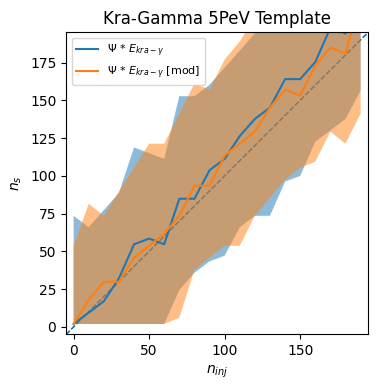

In [11]:
%%time

mp_cpus = 25

runners_to_check = [
    (get_kra_tr, '$\Psi$ * $E_{kra-\gamma}$'),
    (get_kra_tr_mod, '$\Psi$ * $E_{kra-\gamma}$ [mod]'),
]


fig, ax = plt.subplots(1, 1)
for trial_run_func, label in runners_to_check:
    trial_runner = trial_run_func(cpus=mp_cpus)
    allt_i = get_bias_allt(
        trial_runner, ntrials=200, n_sigs=np.r_[:200:10])
    plot_ns_bias(ax, trial_runner, allt_i, label=label)
    
ax.set(title=r'Kra-Gamma 5PeV Template')
ax.legend(fontsize=8)
fig.tight_layout()
fig.savefig('{}/bias_kra_gamma.png'.format(plot_dir))


#### Test Sensitivity/Discovery Potential

In [12]:
%%time

mp_cpus = 25
n_trials = 200000
seed = 592836
tol = 0.03

runners_to_check = [
    (get_kra_tr, '$\Psi$ * $E_{kra-\gamma}$'),
    (get_kra_tr_mod, '$\Psi$ * $E_{kra-\gamma}$ [mod]'),
]

results = {}
bg_trials = {}


for i, (trial_run_func, label) in enumerate(runners_to_check):
    tr = trial_run_func(cpus=mp_cpus)

    bg = cy.dists.Chi2TSD(tr.get_many_fits(
      n_trials, n_sig=0, poisson=False, seed=seed, logging=True))
    print ('Finished bg trials')

    batch_size = 1000
    template_sens = tr.find_n_sig(
        bg.median(), 0.9, n_sig_step=10, seed=seed+4,
          batch_size = batch_size, tol=tol, mp_cups=mp_cpus)
    template_disc = tr.find_n_sig(
        bg.isf_nsigma(5), 0.5, n_sig_step=30, seed=seed+5,
        batch_size=batch_size, tol=tol, mp_cups=mp_cpus)


    for t in [template_sens, template_disc]:
        t['model_norm'] = tr.to_model_norm(t['n_sig'])
        t['model_norm_upper'] = tr.to_model_norm(t['n_sig'] * (1+t['n_sig_error']))
        t['model_norm_lower'] = tr.to_model_norm(t['n_sig'] * (1-t['n_sig_error']))


    results['{}_{:02d}_sens'.format('kra5PeV', i)] = template_sens
    results['{}_{:02d}_disc'.format('kra5PeV', i)] = template_disc
    bg_trials['{}_{:02d}'.format('kra5PeV', i)] = bg



DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Performing 200000 background trials using 25 cores:
     200000/200000 trials complete.   
Finished bg trials
Start time: 2021-12-19 12:27:55.558600
Using 25 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 10.000 ... frac = 0.60000
  n_sig = 20.000 ... frac = 0.76000
  n_sig = 30.000 ... frac = 0.62000
  n_sig = 40.000 ... frac = 0.82000
  n_sig = 50.000 ... frac = 0.76000
  n_sig = 60.000 ... frac = 0.86000
  n_sig = 70.000 ... frac = 0.80000
  n_sig = 80.000 ... frac = 0.88000
  n_sig = 90.000 ... frac = 0.94000
* Generating batches of 1000 trials...
n_trials | n_inj    0.00   36.00   72.00  108.00  144.00  180.00  |  n_sig(relative error)
1000     |         51.1%   76.4%   91.1%   97.0%   99.5%  100.0%  |     68.435 (+/-  4.8%) [chi2.cdf]
2000     |         49.8%   75.9%   91.1%   97.5%   99.6%  

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


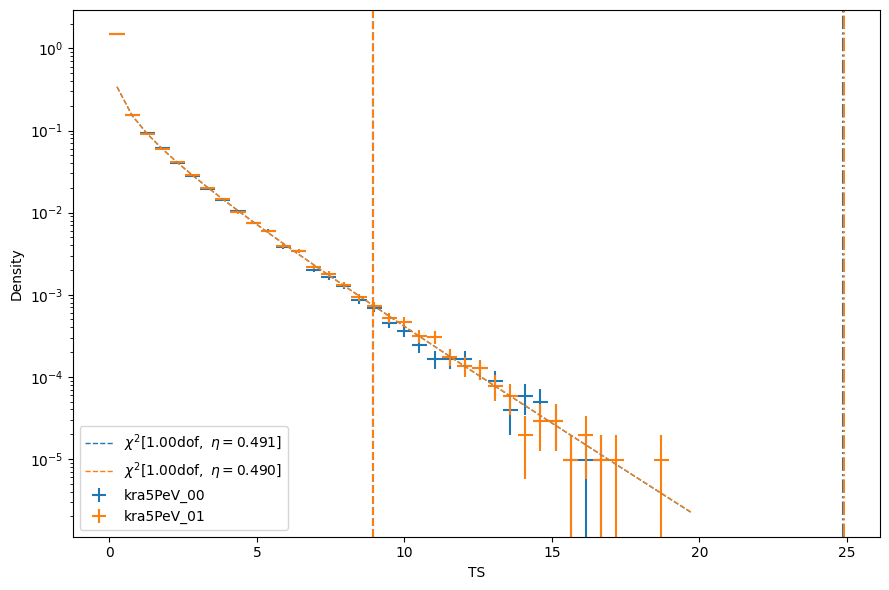

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
bins = np.linspace(0, 20, 40)
for i, (name, bg) in enumerate(bg_trials.items()):
    plot_bkg_trials(bg, fig=fig, ax=ax, label=name, color=colors[i], density=True, bins=bins)
    ax.axvline(bg.isf_nsigma(3), color=colors[i], ls='--')
    ax.axvline(bg.isf_nsigma(5), color=colors[i], ls='-.')

fig.tight_layout()

In [14]:
print('Sensitivity:')
for name, values in results.items():
    i = int(name.split('_')[-2])
    if 'sens' in name:
        print('  {:3.3f} [{:3.3f}, {:3.3f}] | {}'.format(
            values['model_norm'], 
            values['model_norm_lower'], 
            values['model_norm_upper'], 
            runners_to_check[i][1]))

print('5sigma Discovery Potential:')
for name, values in results.items():
    i = int(name.split('_')[-2])
    if 'disc' in name:
        print('  {:3.3f} [{:3.3f}, {:3.3f}] | {}'.format(
            values['model_norm'], 
            values['model_norm_lower'], 
            values['model_norm_upper'], 
            runners_to_check[i][1]))
        

Sensitivity:
  0.165 [0.161, 0.169] | $\Psi$ * $E_{kra-\gamma}$
  0.172 [0.168, 0.176] | $\Psi$ * $E_{kra-\gamma}$ [mod]
5sigma Discovery Potential:
  0.685 [0.678, 0.693] | $\Psi$ * $E_{kra-\gamma}$
  0.689 [0.682, 0.696] | $\Psi$ * $E_{kra-\gamma}$ [mod]


## Test Sources

In [18]:
def model_norm_to_ns(tr, model_norm):
    # get a few values
    norm_100ns = trial_runner.to_model_norm(100)
    
    ns = model_norm / norm_100ns * 100
    assert np.allclose(model_norm, trial_runner.to_model_norm(ns))
    return ns

model_norm_to_ns(tr, model_norm=np.linspace(0.1, 1, 10))


array([ 41.12728491,  82.25456982, 123.38185472, 164.50913963,
       205.63642454, 246.76370945, 287.89099436, 329.01827926,
       370.14556417, 411.27284908])

In [52]:
from cycler import cycle

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)


def test_kra_template(
            model_norm, 
            sigsub=True, cpus=15, 
            n_bg_trials=100000, 
            n_sig_trials=10000, 
        ):
    
    # get trial runner
    trial_runner = get_kra_tr(cpus=cpus, sigsub=sigsub)
    
    # compute expected number of events for given flux
    n_expected = model_norm_to_ns(tr=trial_runner, model_norm=model_norm)
    print('Number of expected signal events: {}'.format(n_expected))
    
    # get background trials
    print('Performing {} BG Trials'.format(n_bg_trials))
    bg = cy.dists.Chi2TSD(trial_runner.get_many_fits(n_trials=n_bg_trials, cpus=cpus))
    
    # get signal trials
    print('Performing {} Signal Trials'.format(n_sig_trials))
    sig_trials = trial_runner.get_many_fits(n_trials=n_sig_trials, cpus=cpus, n_sig=n_expected, poisson=True)
    
    # compute significance
    p_values = bg.sf(sig_trials.ts)
    n_sigma = bg.sf_nsigma(sig_trials.ts)
    
    return sig_trials, bg, p_values, n_sigma, n_expected
        

### Define Sources

In [53]:
source_dict = {}
source_dict_no_ss = {}

for model_norm in np.linspace(0, 1, 11):
    source_dict[model_norm] = dict(model_norm=model_norm, sigsub=True)
    source_dict_no_ss[model_norm] = dict(model_norm=model_norm, sigsub=False)

print('Number of scan points:', len(source_dict), len(source_dict_no_ss))

Number of scan points: 10 10


### Run trials for each source

In [54]:
n_bg_trials = 10000
n_sig_trials = 10000
cpus = 20


In [55]:
results = {}
for name, cfg in source_dict.items():
    print('Running trials for: {}'.format(name))
    sig_tr_i, bg_i, p_values_i, n_sigma_i, n_expected_i = test_kra_template(
        model_norm=cfg['model_norm'],
        cpus=cpus, n_bg_trials=n_bg_trials, n_sig_trials=n_sig_trials,
        sigsub=cfg['sigsub'],
    )
    print()
    
    # save data
    results[name] = {
        'sig_trials': sig_tr_i,
        'bg_trials': bg_i,
        'p_values': p_values_i,
        'n_sigma': n_sigma_i,
        'n_expected': n_expected_i,
    }

    with open(os.path.join(plot_dir, 'trials.pkl'), 'wb') as f:
        pickle.dump(results, f, protocol=2)

Running trials for: 0.0
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 0.0
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   

Running trials for: 0.1111111111111111
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 45.69698323106287
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 45.697 (poisson) using 20 cores:
      10000/10000 trials complete.   

Running trials for: 0.2222222222222222
DNN

In [56]:
results_no_ss = {}
for name, cfg in source_dict_no_ss.items():
    print('Running trials for: {}'.format(name))
    sig_tr_i, bg_i, p_values_i, n_sigma_i, n_expected_i = test_kra_template(
        model_norm=cfg['model_norm'],
        cpus=cpus, n_bg_trials=n_bg_trials, n_sig_trials=n_sig_trials,
        sigsub=cfg['sigsub'],
    )
    print()
    
    # save data
    results_no_ss[name] = {
        'sig_trials': sig_tr_i,
        'bg_trials': bg_i,
        'p_values': p_values_i,
        'n_sigma': n_sigma_i,
        'n_expected': n_expected_i,
    }

    with open(os.path.join(plot_dir, 'trials_no_ss.pkl'), 'wb') as f:
        pickle.dump(results_no_ss, f, protocol=2)

Running trials for: 0.0
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 0.0
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 background trials using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.1111111111111111
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 45.69698323106287
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 45.697 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.2222222222222222
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 91.39396646212575
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 91.394 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.3333333333333333
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 137.09094969318863
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 137.091 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.4444444444444444
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 182.7879329242515
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 182.788 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.5555555555555556
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 228.48491615531435
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 228.485 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.6666666666666666
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 274.18189938637727
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 274.182 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.7777777777777777
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 319.87888261744007
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 319.879 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 0.8888888888888888
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 365.575865848503
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 365.576 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   

Running trials for: 1.0
DNNCascade_10yr           | Acceptance weighting complete.                    
DNNCascade_10yr           | Smearing complete.                              
Number of expected signal events: 411.2728490795659
Performing 10000 BG Trials
Performing 10000 background trials using 20 cores:
      10000/10000 trials complete.   
Performing 10000 Signal Trials
Performing 10000 trials with n_sig = 411.273 (poisson) using 20 cores:


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2404: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2405: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_methods.py:209:

      10000/10000 trials complete.   



In [57]:
with open(os.path.join(plot_dir, 'trials.pkl'), 'rb') as f:
    results = pickle.load(f)
    
with open(os.path.join(plot_dir, 'trials_no_ss.pkl'), 'rb') as f:
    results_no_ss = pickle.load(f)

### Make Plots

0.0

0.1111111111111111

0.2222222222222222

0.3333333333333333

0.4444444444444444

0.5555555555555556

0.6666666666666666


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



0.7777777777777777

0.8888888888888888

1.0



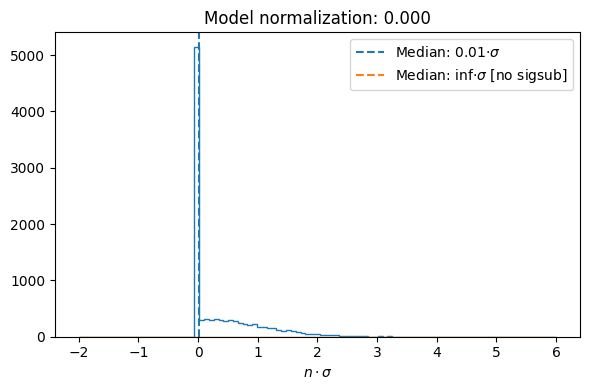

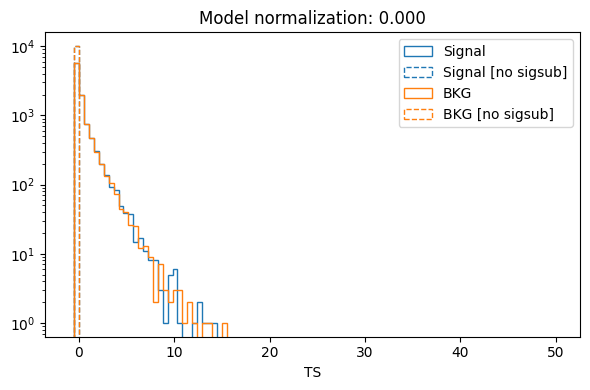

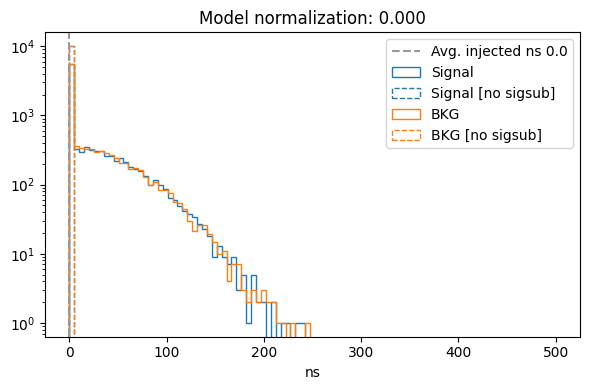

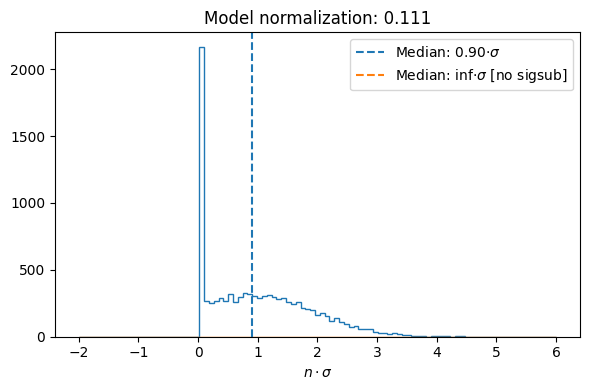

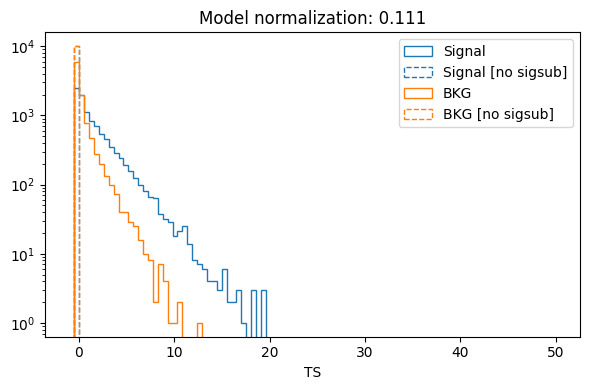

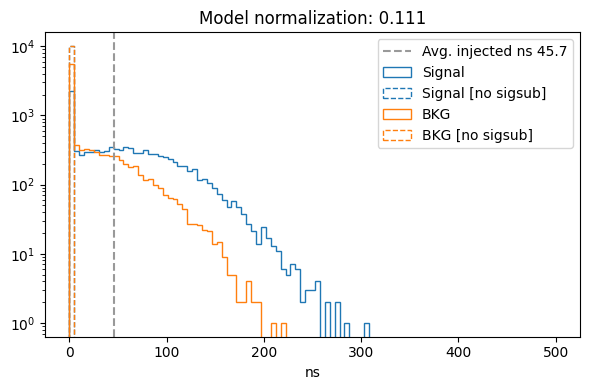

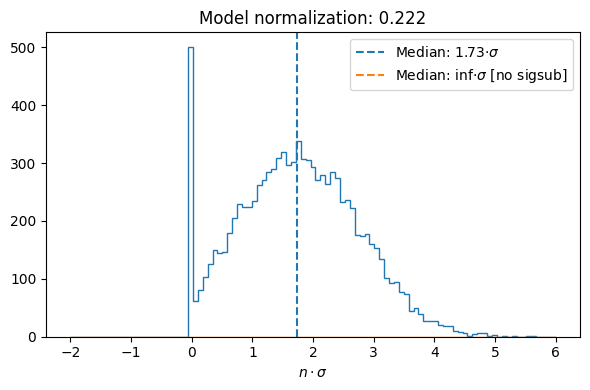

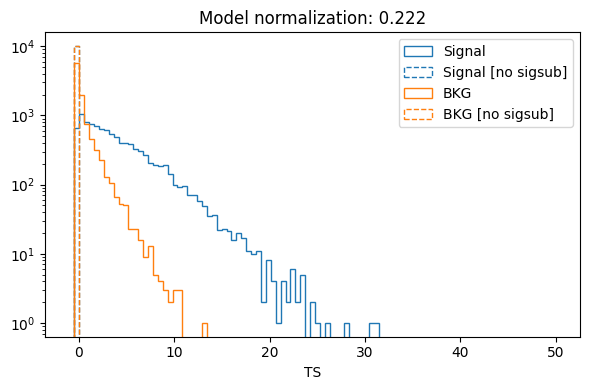

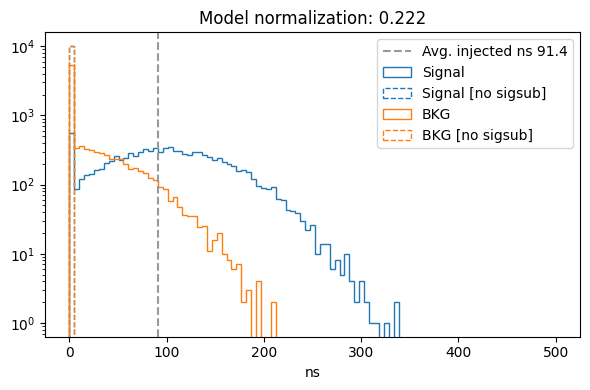

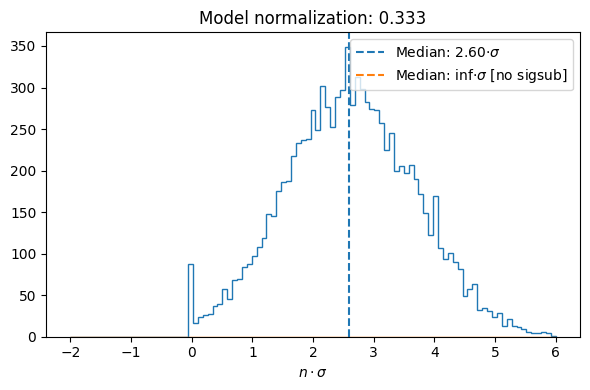

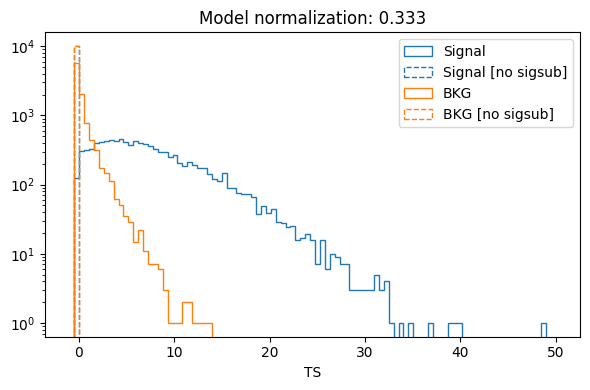

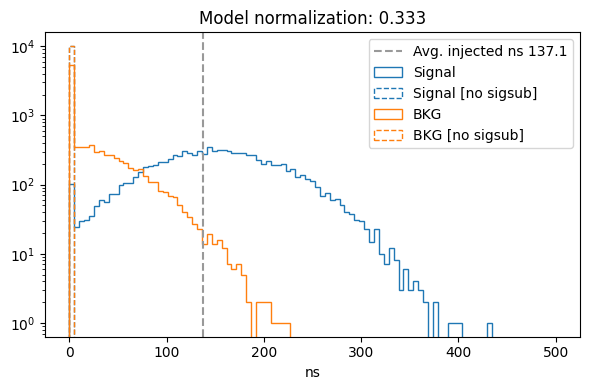

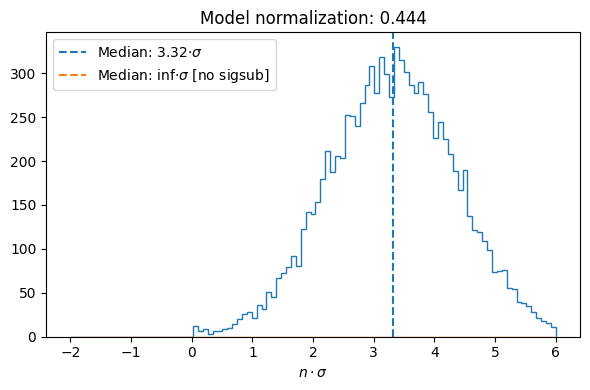

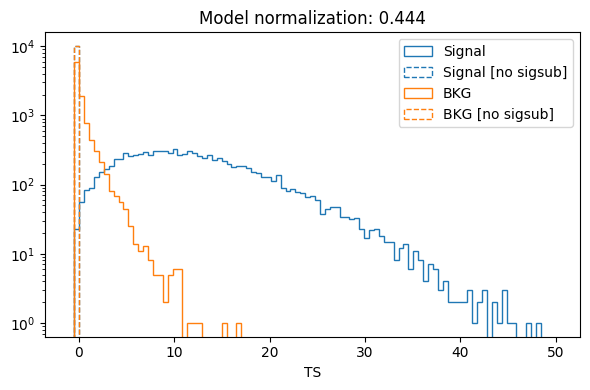

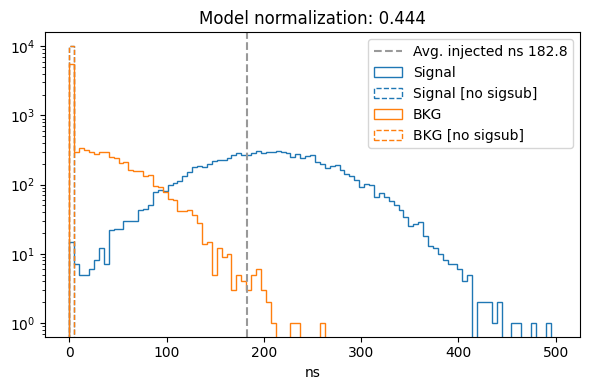

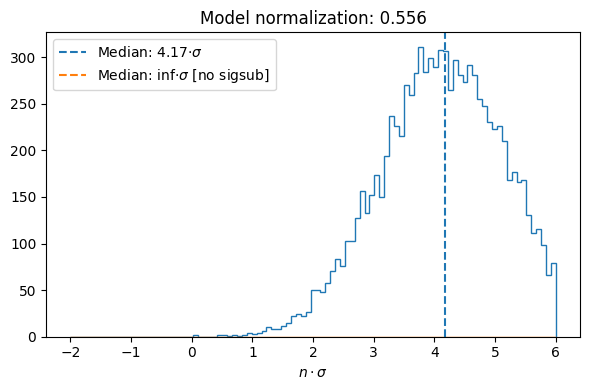

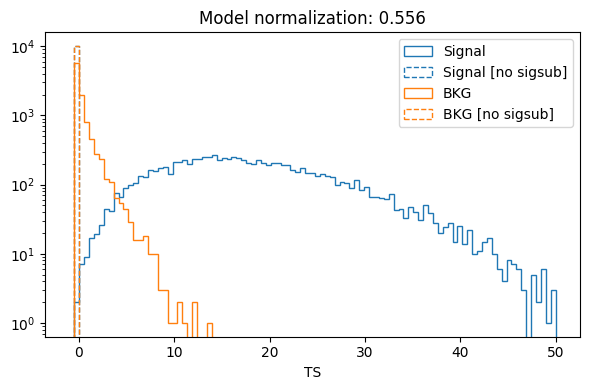

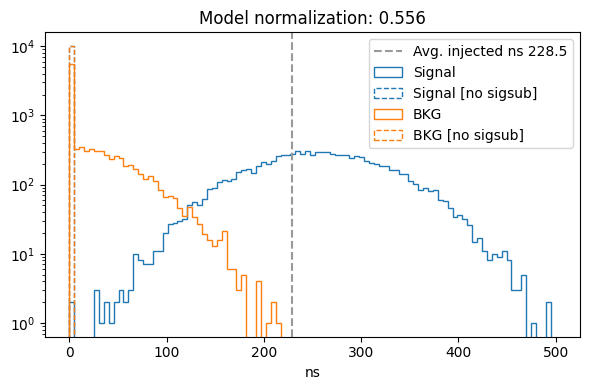

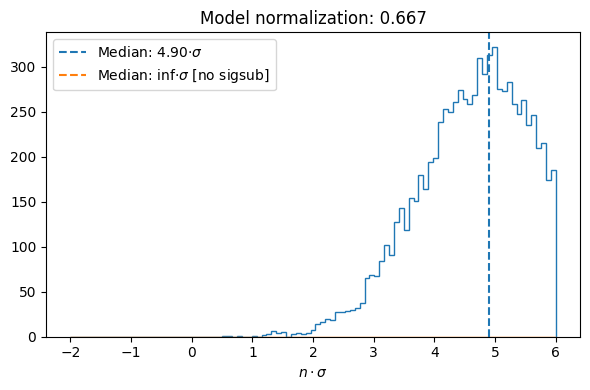

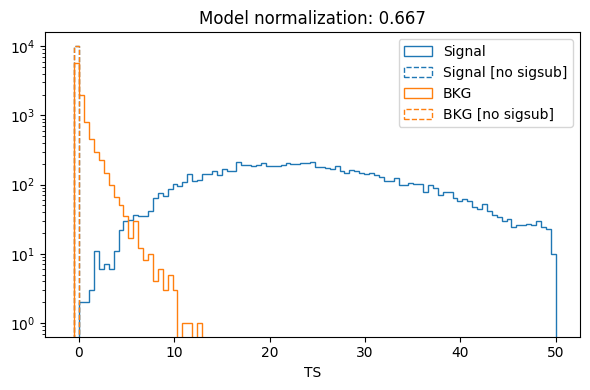

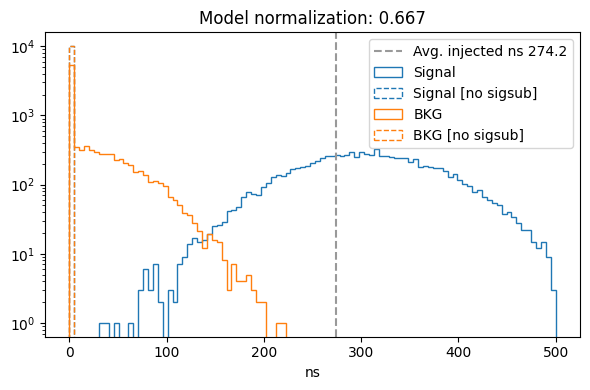

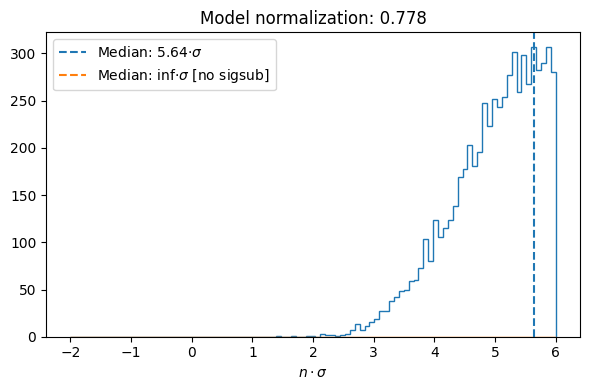

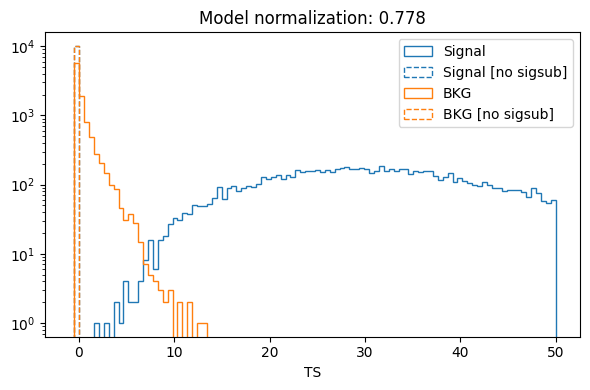

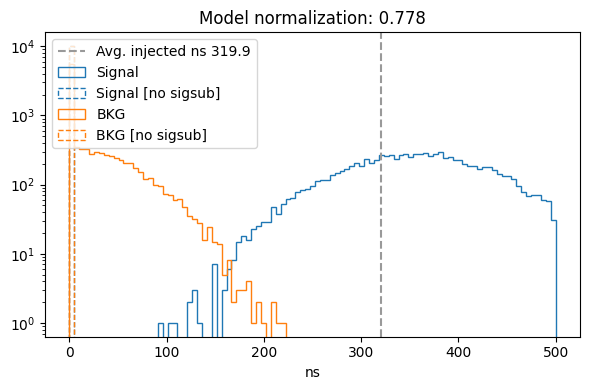

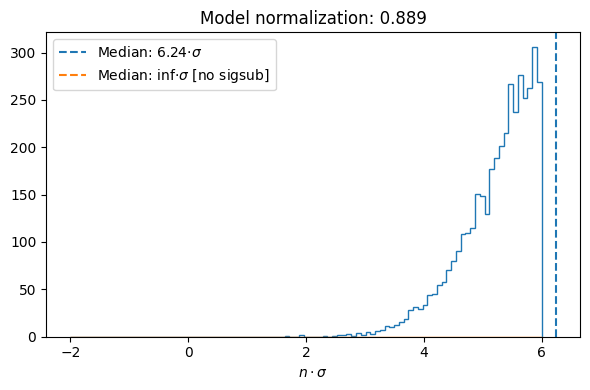

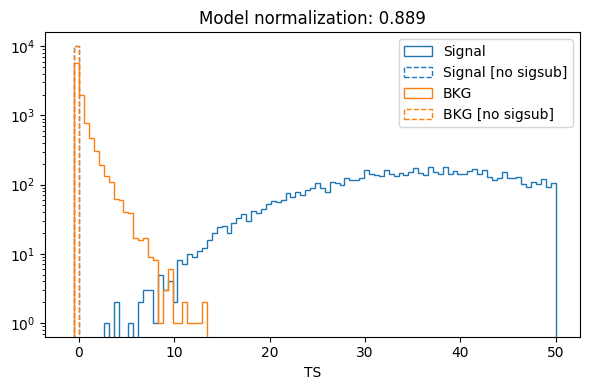

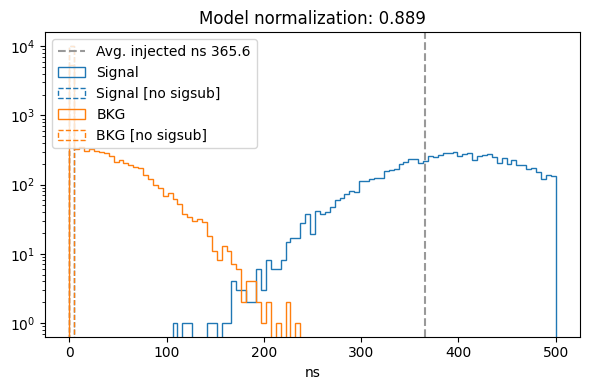

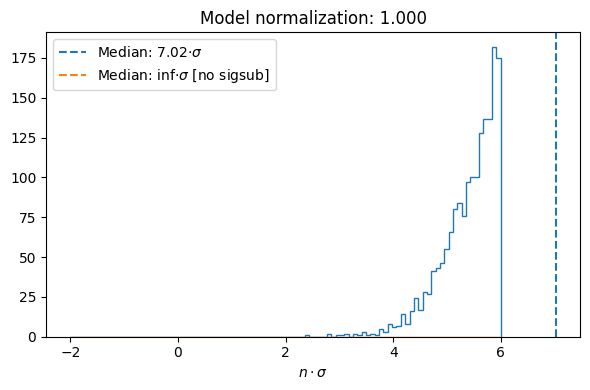

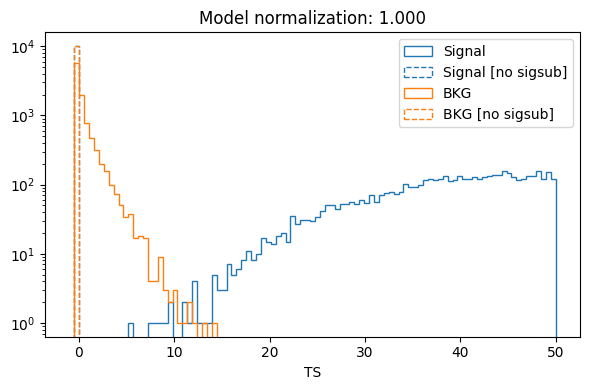

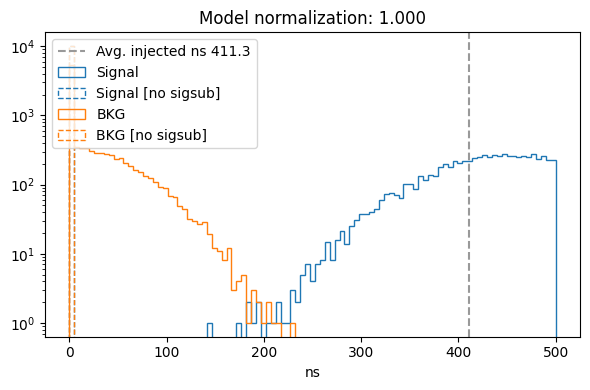

In [63]:

for name, res in results.items():
    res_no_ss = results_no_ss[name]
    print(name)
    
    fname = str(name)
    title = r'Model normalization: {:3.3f}'.format(name)
    
    mask = res['sig_trials'].ns != 0
    mask_bkg = res['bg_trials'].trials.ns != 0
    
    # -----------------
    # Significance Plot
    # -----------------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(-2, 6, 100)
    ax.hist(res['n_sigma'], bins=bins, histtype='step', color=colors[0])
    ax.hist(res_no_ss['n_sigma'], bins=bins, histtype='step', color=colors[1])
    ax.axvline(np.median(res['n_sigma']), ls='--', color=colors[0], label='Median: {:3.2f}$\cdot \sigma$'.format(np.median(res['n_sigma'])))
    ax.axvline(np.median(res_no_ss['n_sigma']), ls='--', color=colors[1], label='Median: {:3.2f}$\cdot \sigma$ [no sigsub]'.format(np.median(res_no_ss['n_sigma'])))
    ax.legend()
    ax.set_xlabel('$n \cdot \sigma$')
    ax.set_title(title)
    #ax.set_xscale('log')
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_significance.png'))
    
    # -------
    # TS Plot
    # -------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(-1, 50, 100)
    ax.hist(res['sig_trials'].ts, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res_no_ss['sig_trials'].ts, bins=bins, histtype='step', ls='--', label='Signal [no sigsub]', color=colors[0])
    ax.hist(res['bg_trials'].trials.ts, bins=bins, histtype='step', label='BKG', color=colors[1])
    ax.hist(res_no_ss['bg_trials'].trials.ts, bins=bins, ls='--', histtype='step', label='BKG [no sigsub]', color=colors[1])
    #ax.axvline(np.median(res['sig_trials'].ts), ls='--', color='0.6', label='Median')
    #ax.axvline(np.median(res['bg_trials'].trials.ts), ls='--', color='0.6')
    ax.legend()
    ax.set_xlabel('TS')
    ax.set_yscale('log')
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_ts.png'))
    
    # -------
    # ns Plot
    # -------
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.linspace(0, 500, 100)
    ax.hist(res['sig_trials'].ns, bins=bins, histtype='step', label='Signal', color=colors[0])
    ax.hist(res_no_ss['sig_trials'].ns, bins=bins, histtype='step', ls='--', label='Signal [no sigsub]', color=colors[0])
    ax.hist(res['bg_trials'].trials.ns, bins=bins, histtype='step',label='BKG', color=colors[1])
    ax.hist(res_no_ss['bg_trials'].trials.ns, bins=bins, histtype='step', ls='--', label='BKG [no sigsub]', color=colors[1])
    ax.set_xlabel('ns')
    ax.set_yscale('log')
    ax.set_title(title)
    ax.axvline(res['n_expected'], ls='--', color='0.6', label='Avg. injected ns {:3.1f}'.format(res['n_expected']))
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, fname + '_ns.png'))

    print()

#### Make significance scan plot

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'ls', 'lw'
  del sys.path[0]


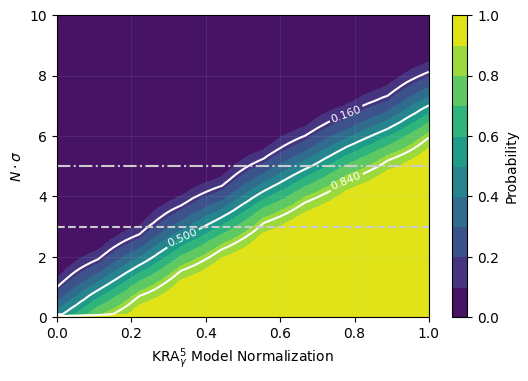

In [108]:
n_sigmas = np.linspace(0, 10, 100)

probs = np.empty((len(results), len(n_sigmas)))
model_norms = sorted(results.keys())

for i, (name, res) in enumerate(results.items()):
    for j, n_sigma in enumerate(n_sigmas):
        mask = res['n_sigma'] >= n_sigma
        probs[i, j] = np.sum(mask) / len(res['n_sigma'])

fig, ax = plt.subplots()
#im = ax.contour(model_norms, n_sigmas, probs.T, levels=[0.5, 0.9], colorbar='black')
contours = ax.contour(model_norms, n_sigmas, probs.T, levels=[0.16, 0.5, 0.84], colors='1.0', ls='--', lw=3)
plt.clabel(contours, inline=True, fontsize=8)
im = ax.contourf(model_norms, n_sigmas, probs.T, levels=np.linspace(0, 1, 11))
ax.set_xlabel('$\mathrm{KRA}_\gamma^5$ Model Normalization')
ax.set_ylabel('$N \cdot \sigma$')
ax.axhline(3, color='0.8', ls='--')
ax.axhline(5, color='0.8', ls='-.')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Probability')
ax.grid(color='0.8', alpha=0.1)

fig.savefig(os.path.join(plot_dir, 'kra_gamma_5pev_sigma_scan.png'))
